### Summary
This notebook will plot lat/lon coordinates of Boston area establishments with a liquor license.


### Notebook output
All plots saved from this notebook will be located at `../figures/liquor/`

In [200]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [201]:
DATA_ROOT = '../data/'
DATA_DIR = os.path.join(DATA_ROOT, 'processed')
readfile_liquor = os.path.join(DATA_DIR, 'liquor_processed.csv')

In [202]:
df_liquor_eda = pd.read_csv(readfile_liquor)
df_liquor_eda.head(3)

,Unnamed: 0,LICENSENO,LICSTATUS,LICCAT,LICCATDESC,Address_Complete,Location_Complete
0,0,LB-101572,Active,GOPAL,GOP All Alc.,Central Wharf Boston MA,"(42.35909945, -71.0495668203563)"
1,1,LB-101576,Active,GOPAL,GOP All Alc.,Boylston PL Boston MA,"(42.316157, -71.102592)"
2,2,LB-101577,Active,GOPAL,GOP All Alc.,State ST Boston MA,"(42.3588444, -71.0572152)"


In [203]:
#Format Location_Complete to separate lat/lon columns
coordinates_format = df_liquor_eda['Location_Complete'].str.strip('()')               \
                   .str.split(', ', expand=True)                \
                   .rename(columns={0:'Latitude', 1:'Longitude'}) 


In [204]:
df_liquor_eda['Latitude'] = coordinates_format['Latitude']
df_liquor_eda['Longitude'] = coordinates_format['Longitude']

df_liquor_eda['Latitude'] = df_liquor_eda['Latitude'].astype(float)
df_liquor_eda['Longitude'] = df_liquor_eda['Longitude'].astype(float)

df_liquor_eda.head(3)

,Unnamed: 0,LICENSENO,LICSTATUS,LICCAT,LICCATDESC,Address_Complete,Location_Complete,Latitude,Longitude
0,0,LB-101572,Active,GOPAL,GOP All Alc.,Central Wharf Boston MA,"(42.35909945, -71.0495668203563)",42.359099,-71.049567
1,1,LB-101576,Active,GOPAL,GOP All Alc.,Boylston PL Boston MA,"(42.316157, -71.102592)",42.316157,-71.102592
2,2,LB-101577,Active,GOPAL,GOP All Alc.,State ST Boston MA,"(42.3588444, -71.0572152)",42.358844,-71.057215


In [205]:
# delete all rows in Charlestown with incorrect coordinates
drop_values = df_liquor_eda[(df_liquor_eda['Address_Complete'] == 'Main ST Charlestown MA') 
                            | (df_liquor_eda['Address_Complete'] == 'Main St Charlestown MA')].index
df_liquor_eda.drop(drop_values, inplace=True)

In [206]:
#Validate record change down to 1103, save as new "final" processed .csv for other group members

df_liquor_eda.to_csv('../data/processed/liquor_processed_final.csv', sep=',')
len(df_liquor_eda)

1103

In [207]:
#Map plot prep

# read in SAM address data and related shapefiles
df_crime = pd.read_csv(readfile_crime, dtype=str)
df_sam = pd.read_csv(readfile_sam, dtype=str)
gdf_zips = gpd.read_file(readfile_zipshapes)
gdf_boston = gpd.read_file(readfile_cityshape)
gdf_streets = gpd.read_file(readfile_streetshapes)
gdf_tracts = gpd.read_file(readfile_tractshapes)
gdf_hoods = gpd.read_file(readfile_hoodshapes)
gdf_zonesubs = gpd.read_file(readfile_zonesubshapes)


# convert SAM data lat/lon values to floats
df_sam[['X', 'Y']] = df_sam[['X', 'Y']].astype(float)
# convert crime data lat/lon values to floats
df_crime[['Lat', 'Long']] = df_crime[['Lat', 'Long']].astype(float)

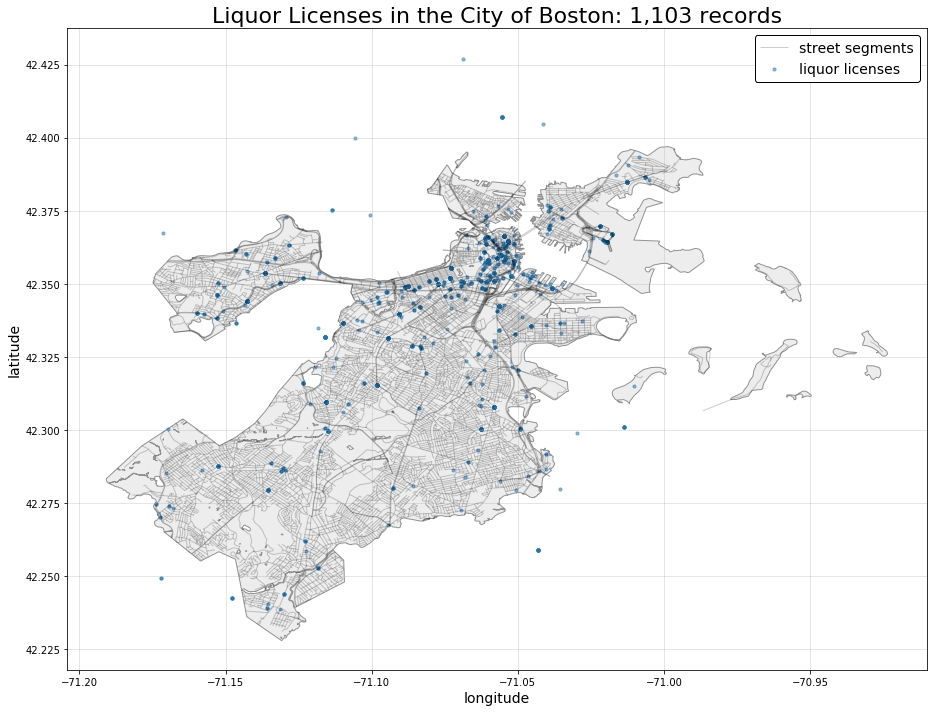

In [210]:
# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='k', linewidth=1, alpha=0.2, label='street segments')
plt.title(
    'Liquor Licenses in the City of Boston: 1,103 records',
    fontsize=22
)
plt.scatter(
    df_liquor_eda['Longitude'], df_liquor_eda['Latitude'],
    
    color='tab:blue', alpha=.5, s=10,
    label='liquor licenses'
)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
plt.show();

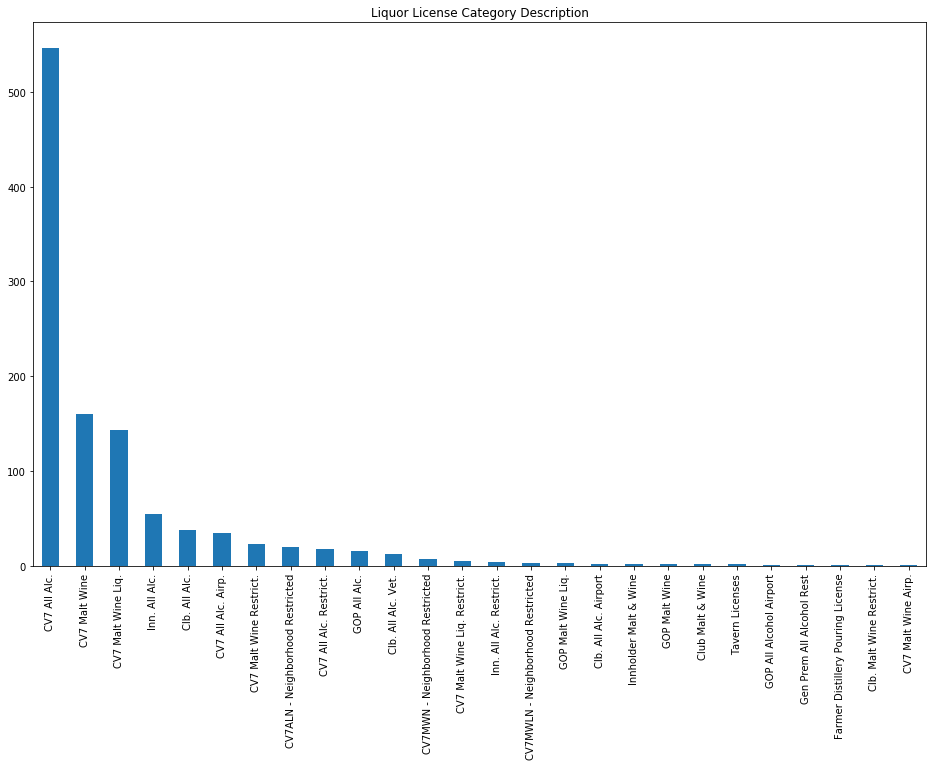

In [242]:
#Adding simple bar plot for different liquor category desciptions by frequency

df_liquor_eda['LICCATDESC'].value_counts().plot(kind='bar',figsize=(16, 10),title='Liquor License Category Description')

In [238]:
#Simplifying these liquor descriptions into the following categories

#   Abbr       Type
#   GOP        "General On-Premises"
#   Gen        "General On-Premises"
#   CV7        "Common Vectualler"
#   Club       Club
#   Clb        Club
#   Inn        Hotel
#   Tavern     Tavern
#   "Farmer Distillery" "Farmer Distillery"

matched_values = [['GOP', 'General On-Premises'], ['Gen', 'General On-Premises'], ['CV7', 'Common Victualler'],
                  ['Club','Club'],['Clb','Club'],['Inn','Hotel'],['Tavern','Tavern'],
                  ['Farmer Distillery','Farmer Distillery']] 

df_matched_values = pd.DataFrame(matched_values, columns = ['Abbreviation', 'Liquor_Category_Description']) 


In [239]:
df_liquor_eda['Abbreviation'] = df_liquor_eda['LICCATDESC'].str[:3]
results = df_liquor_eda.merge(df_matched_values,on='Abbreviation')

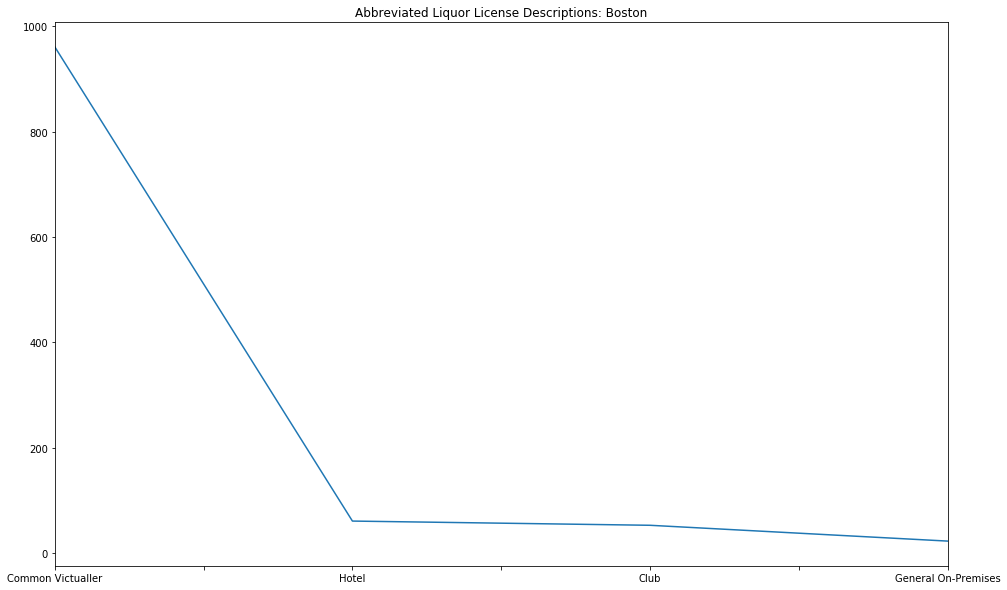

In [243]:
results['Liquor_Category_Description'].value_counts().plot(kind='line',title = 'Abbreviated Liquor License Descriptions: Boston'
                                                           ,figsize=(16, 10))

In [244]:
#Notes:
#This plot illustrates the most common liquor license in boston as "Common Victualler" which means: 
#"A Common Victualler’s license is required for any establishment that has on its premises the ability to assemble, 
#prepare, or cook food and has seating for the purpose of consuming that food on the premises"